In [1]:
import json
import logging
import os
import pickle
import sys
from itertools import combinations
from multiprocessing import Pool
from pymoo.algorithms.soo.nonconvex.ga import GA
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.core.repair import Repair
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
import matplotlib.pyplot as plt
import random
import dill
from pymoo.termination import get_termination
import kaleido

In [2]:
class CustomRepair(Repair):

    # Checkt welche elemente die meisten kollisionen verursachen und deaktiviert diese
    def smart_repair(self, item):
        row = item[0]
        idx = item[1]
        indices = np.where(row)[0]
        combs = combinations(indices, 2)
        collisions = {}
        for combination in combs:
            WKA1 = points[combination[0]]
            WKA2 = points[combination[1]]
            WKA1_type = WKAs[WKA1[0]]
            WKA2_type = WKAs[WKA2[0]]
            d = WKA1[1].distance(WKA2[1])
            if 3 * WKA1_type["rotor_diameter_in_meter"] > d:
                if combination[0] in collisions:
                    collisions[combination[0]].append(combination[1])
                else:
                    collisions[combination[0]] = [combination[1]]
            if 3 * WKA2_type["rotor_diameter_in_meter"] > d:
                if combination[1] in collisions:
                    collisions[combination[1]].append(combination[0])
                else:
                    collisions[combination[1]] = [combination[0]]
        colls_sorted = sorted(collisions.items(), key=lambda elem: len(elem[1]), reverse=True)
        colls_sorted_as_np = np.asarray([val[0] for val in colls_sorted])
        if not colls_sorted_as_np.shape == (0,):
            for key in colls_sorted_as_np:
                if key in collisions:
                    row[key] = False
                    collisions.pop(key, None)
                    subarray = sorted(collisions.items(), key=lambda elem: len(elem[1]), reverse=True)
                    subarray_np = np.asarray([val[0] for val in subarray])
                    if not subarray_np.shape == (0,):
                        for subkey in subarray_np:
                            if subkey in collisions:
                                if key in collisions[subkey]:
                                    collisions[subkey].remove(key)
                                    if len(collisions[subkey]) == 0:
                                        collisions.pop(subkey, None)
        return (idx, row)

    def random_repair(self, item):
        '''
        Identical to repair_mp besides the randomized choice of the the element that should be removed.
        :param item:
        :return:
        '''
        row = item[0]
        idx = item[1]
        indices = np.where(row)[0]
        combs = combinations(indices, 2)
        for combination in combs:
            WKA1 = points[combination[0]]
            WKA2 = points[combination[1]]
            WKA1_type = WKAs[WKA1[0]]
            WKA2_type = WKAs[WKA2[0]]
            d = WKA1[1].distance(WKA2[1])
            if 3 * WKA1_type["rotor_diameter_in_meter"] > d or 3 * WKA2_type["rotor_diameter_in_meter"] > d:
                row[combination[random.choice([0, 1])]] = False
        return (idx, row)

    def repair_mp(self, item):
        row = item[0]
        idx = item[1]
        indices = np.where(row)[0]
        combs = combinations(indices, 2)
        for combination in combs:
            WKA1 = points[combination[0]]
            WKA2 = points[combination[1]]
            WKA1_type = WKAs[WKA1[0]]
            WKA2_type = WKAs[WKA2[0]]
            d = WKA1[1].distance(WKA2[1])
            # Alt und Falsch: if 3 * WKA1_type["rotor_diameter_in_meter"] < d and 3 * WKA2_type["rotor_diameter_in_meter"] < d:
            if 3 * WKA1_type["rotor_diameter_in_meter"] > d or 3 * WKA2_type["rotor_diameter_in_meter"] > d:
                row[combination[
                    0]] = False  # Todo: Sinnvollen ersatz Finden, einfach durch random choice ersetzen verschlechtert das ergebnis einfach
        return (idx, row)

    def _do(self, problem, X, **kwargs):
        row_gen = (x for x in X)
        indices = np.arange(X.shape[0])

        if REPAIR == "smart_repair":
            res = pool.map(self.smart_repair, zip(row_gen, indices))
        elif REPAIR == "simple":
            res = pool.map(self.repair_mp, zip(row_gen, indices))
        elif REPAIR == "random":
            res = pool.map(self.random_repair, zip(row_gen, indices))

        # Evtl überflüssig
        res.sort(key=lambda elem: elem[0])
        for idx, item in res:
            X[idx, :] = item
        return X


class WindEnergySiteSelectionProblem(Problem):

    def __init__(self, **kwargs):
        super().__init__(n_var=points.shape[0], n_obj=1, n_ieq_constr=1, xl=0.0,
                         xu=1.0, **kwargs)  # Bearbeitet weil v_var nicht mehr gepasst hat

    def const_check(self, item):
        row = item[0]
        idx = item[1]
        indices = np.where(row)[0]
        combs = combinations(indices, 2)
        constraints_np = -1
        for combination in combs:
            WKA1 = points[combination[0]]
            WKA2 = points[combination[1]]
            WKA1_type = WKAs[WKA1[0]]
            WKA2_type = WKAs[WKA2[0]]
            d = WKA1[1].distance(WKA2[1])
            if 3 * WKA1_type["rotor_diameter_in_meter"] > d or 3 * WKA2_type["rotor_diameter_in_meter"] > d:
                constraints_np = 1
                break
        return (idx, constraints_np)

    def _evaluate(self, X, out, *args, **kwargs):

        constraints_np = np.empty((X.shape[0]))
        row_gen = (x for x in X)
        indices = np.arange(X.shape[0])

        res = pool.map(self.const_check, zip(row_gen, indices))
        res.sort(key=lambda elem: elem[0])
        for idx, item in res:
            constraints_np[idx] = item

        # Ab hier werden die kosten berechnet
        vals = np.where(X, points[:, 0], "")

        uniques, count = np.unique(vals, return_counts=True)

        type_prices = {}
        for idx, item in enumerate(uniques):
            if item == "":
                continue
            building_price = WKAs[item]["price"]["price_building"]
            price_per_year = WKAs[item]["price"]["price_per_year"]
            sum_price_one = building_price + (price_per_year * WKAs[item]["life_expectancy_in_years"])
            type_prices[item] = sum_price_one

        for key, value in type_prices.items():
            vals[vals == key] = value
        vals[vals == ""] = 0
        vals_sum = np.sum(vals, axis=1)

        # Ab hier wird die energie produktion berechnet
        # Grundlage für Energieberechnung https://www.energie-lexikon.info/megawattstunde.html
        vals_ = np.where(X, points[:, 0], "")
        uniques, count = np.unique(vals_, return_counts=True)

        type_energy = {}
        for idx, item in enumerate(uniques):
            if item == "":
                continue
            nominal_power = WKAs[item]["nominal_power_in_kW"]
            lifetime_hours = WKAs[item][
                                 "life_expectancy_in_years"] * 8760  # Laut google ist 1 Jahr 8760 stunden # trifft nicht auf schaltjahre zu. Dort sind es 8784
            kwh = nominal_power * lifetime_hours
            type_energy[item] = kwh

        for key, value in type_energy.items():
            vals_[vals_ == key] = value
        vals_[vals_ == ""] = 0
        vals__sum = np.sum(vals_, axis=1)
        vals__sum = vals__sum * strompreis
        result = vals__sum - vals_sum
        result = -result
        out["F"] = result
        out["G"] = np.asarray([constraints_np])


In [3]:
with open(r"C:\workspace\Study_Project_Wind_Energy\Results\saves_Simple_Repair\res.dill", "rb") as file:
    res = dill.load(file)


In [4]:
import pandas as pd

In [5]:
d = {}
d["Fitness_vals"] = []
fitness_vals = []
for iteration in res.history:
    x = []
    for item in iteration.pop:
        x.append(item.F[0])
    fitness_vals.append(x)
np_fitness = np.asarray(fitness_vals)
for i in range(np_fitness.shape[0]):
    d["Fitness_vals"].append(np_fitness[i,:])
d["Generations"] = list(range(0,100))

In [6]:
df = pd.DataFrame.from_dict(d)

In [7]:
df

,Fitness_vals,Generations
0,"[-12596026000.0, -12578362000.0, -12684198000....",0
1,"[-13691126000.0, -13645480000.0, -13611322000....",1
2,"[-13749430000.0, -13691126000.0, -13645480000....",2
3,"[-13757998000.0, -13749430000.0, -13702804000....",3
4,"[-13757998000.0, -13749430000.0, -13737478000....",4
...,...,...
95,"[-22005398000.0, -21992994000.0, -21981958000....",95
96,"[-22087078000.0, -22064872000.0, -22040262000....",96
97,"[-22170056000.0, -22169086000.0, -22136360000....",97
98,"[-22212518000.0, -22172848000.0, -22172006000....",98


In [8]:
import seaborn as sns

In [6]:
#Richtige Generation
d = {}
d["Generations"] = []
d["Fitness"] = []
for i in range(np_fitness.shape[0]):
    for j in range(np_fitness.shape[1]):
        d["Generations"].append(i)
        d["Fitness"].append(np_fitness[i,j])

df = pd.DataFrame.from_dict(d)

In [20]:
df["std"] = df["Fitness"].rolling(10).std()
df["avg"] = df["Fitness"].rolling(10).mean()
df["avg2"] = df["Fitness"].rolling(20).mean()

In [8]:
df

,Generations,Fitness,std,avg
0,0,-1.259603e+10,NaN,NaN
1,0,-1.257836e+10,NaN,NaN
2,0,-1.268420e+10,NaN,NaN
3,0,-1.163566e+10,NaN,NaN
4,0,-1.361132e+10,NaN,NaN
...,...,...,...,...
9995,99,-2.206033e+10,1.800005e+06,-2.206282e+10
9996,99,-2.205747e+10,2.310981e+06,-2.206208e+10
9997,99,-2.205727e+10,2.529514e+06,-2.206132e+10
9998,99,-2.205676e+10,2.623619e+06,-2.206054e+10


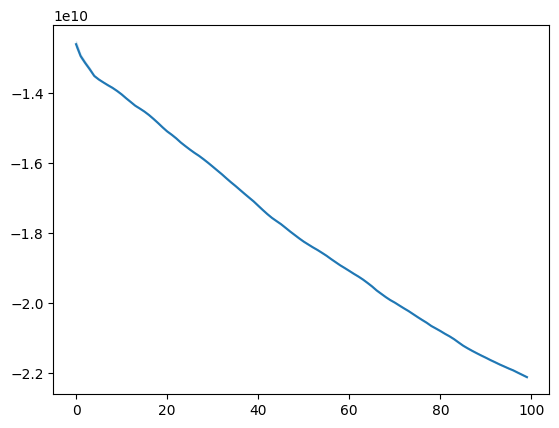

In [53]:
Fitness = df["Fitness"].to_numpy()
Generations = df["Generations"].to_numpy()
ax = sns.lineplot(x=Generations, y=Fitness)

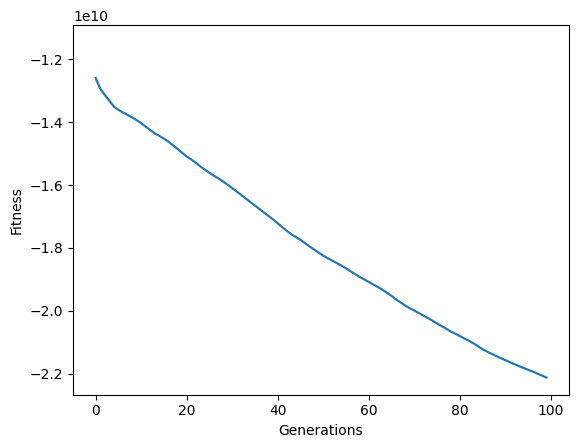

In [50]:
ax = sns.lineplot(x="Generations", y="Fitness", data=df)
ax.fill_between(df["Generations"], y1=df["Fitness"] - df["std"], y2=df["Fitness"] + df["std"])

In [30]:
import plotly.express as px

In [10]:
import plotly.graph_objs as go

In [23]:

fig = go.Figure([
    go.Scatter(
        name='Gewinn',
        x=df['Generations'],
        y=df['Fitness'],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
    go.Scatter(
        name='Upper Bound',
        x=df['Generations'],
        y=df["avg"]+df['std'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=df['Generations'],
        y=df["avg"]-df['std'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    )
])
fig.update_layout(
    yaxis_title='Wind speed (m/s)',
    title='Gewinne',
    hovermode="x"
)
fig.show()


In [18]:
fig.write_image(r"C:\workspace\Study_Project_Wind_Energy\fig1.png")

In [ ]:
df2 = df.groupby("Generations")

In [13]:
import plotly.io as pio
pio.templates

Templates configuration
-----------------------
    Default template: 'plotly_dark'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']

In [15]:
pio.templates.default = "plotly"